In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

구글의 Colab에서 '런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU'를 선택하면 USE_CUDA의 값이 True가 되면서 '다음 기기로 학습합니다: cuda'라는 출력이 나옵니다. 즉, GPU로 연산하겠다는 의미입니다. 반면에 '하드웨어 가속기 > None'을 선택하면 USE_CUDA의 값이 False가 되면서 '다음 기기로 학습합니다: cpu'라는 출력이 나옵니다. 즉, CPU로 연산하겠다는 의미입니다.

위의 방법은 앞으로 자주 쓰이게되므로 기억해둡시다.

In [2]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [3]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
# hyperparameters
training_epochs = 15
batch_size = 100

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='../MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='../MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

100.1%

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


113.5%

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


100.4%

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


180.4%

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/Users/distiller/project/conda/conda-bld/pytorch_1591914925853/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


첫번째 인자 root는 MNIST 데이터를 다운로드 받을 경로입니다. 두번째 인자 train은 인자로 True를 주면, MNIST의 훈련 데이터를 리턴받으며 False를 주면 테스트 데이터를 리턴받습니다. 세번째 인자 transform은 현재 데이터를 파이토치 텐서로 변환해줍니다. 네번째 인자 download는 해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다는 의미입니다.

이렇게 데이터를 다운로드했다면 앞서 미니 배치와 데이터로드 챕터에서 학습했던 데이터로더(DataLoader)를 사용합니다.

In [5]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

이때 DataLoader에는 4개의 인자가 있습니다. 첫번째 인자인 DataLoader는 로드할 대상을 의미하며, 두번째 인자인 batch_size는 배치 크기, shuffle은 매 에포크마다 미니 배치를 셔플할 것인지의 여부, drop_last는 마지막 배치를 버릴 것인지를 의미합니다.

drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.

In [6]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)

to() 함수는 연산을 어디서 수행할지를 정합니다. to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보냅니다. CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있습니다. 아무것도 지정하지 않은 경우에는 CPU 연산이라고 보면 됩니다.

bias는 편향 b를 사용할 것인지를 나타냅니다. 기본값은 True이므로 굳이 할 필요는 없지만 명시적으로 True를 해주었습니다.
이제 비용 함수와 옵티마이저를 정의합니다.

In [7]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

앞서 소프트맥스 회귀를 배울 때는 torch.nn.functional.cross_entropy()를 사용하였으나 여기서는 torch.nn.CrossEntropyLoss()을 사용하고 있습니다. 둘 다 파이토치에서 제공하는 크로스 엔트로피 함수로 둘 다 소프트맥스 함수를 포함하고 있습니다.

In [8]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.535468519
Epoch: 0002 cost = 0.359274209
Epoch: 0003 cost = 0.331187546
Epoch: 0004 cost = 0.316578060
Epoch: 0005 cost = 0.307158172
Epoch: 0006 cost = 0.300180733
Epoch: 0007 cost = 0.295130223
Epoch: 0008 cost = 0.290851533
Epoch: 0009 cost = 0.287417084
Epoch: 0010 cost = 0.284379601
Epoch: 0011 cost = 0.281825215
Epoch: 0012 cost = 0.279800713
Epoch: 0013 cost = 0.277808994
Epoch: 0014 cost = 0.276154280
Epoch: 0015 cost = 0.274440855
Learning finished


Accuracy: 0.8863000273704529
Label:  8
Prediction:  3


/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


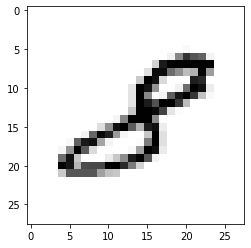

In [9]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()